In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!nvidia-smi
!pip install -U git+https://github.com/qubvel/efficientnet

Mon Jun 15 12:17:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%tensorflow_version 2.x

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
import tensorflow.keras.callbacks as cb
import tensorflow.keras.layers as L
import tensorflow.keras as K
import tensorflow as tf

import efficientnet.tfkeras as efn
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from glob import glob
import os, zipfile, cv2, csv, shutil

# tf.keras.backend.set_learning_phase(True)

# 載入資料
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 100
STEPS = 128
NUM_CLASSES = 3
DATASET_PATH = '/content/datasets'       # 資料路徑

In [ ]:
if not os.path.exists('datasets'):
    f = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/datasets_9.zip")
    f.extractall("./")

# 資料增強 ImageDataGenerator

In [ ]:
# [-1, 1]
def preprocess_fn1(im_array):
    return im_array / 127.5 -1

trn_dagen = ImageDataGenerator(rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                            #    shear_range=0.1,
                            #    zoom_range=0.1,
                               horizontal_flip=True,
                               vertical_flip = True, 
                            #    brightness_range= [0.5, 1.5],
                               preprocessing_function= preprocess_fn1,
                               fill_mode='nearest')

trn_gen = trn_dagen.flow_from_directory(os.path.join(DATASET_PATH, 'train'),
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=True)

val_eva_dagen = ImageDataGenerator(preprocessing_function= preprocess_fn1,
                                   validation_split=0.5)

val_gen = val_eva_dagen.flow_from_directory(os.path.join(DATASET_PATH, 'test'),
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size= BATCH_SIZE,
                                            class_mode='categorical',
                                            shuffle=True,
                                            subset='training')
                                            
eva_gen = val_eva_dagen.flow_from_directory(os.path.join(DATASET_PATH, 'test'),
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size= BATCH_SIZE * 3,
                                            class_mode='categorical',
                                            shuffle=True,
                                            subset='validation')

Found 7260 images belonging to 3 classes.
Found 239 images belonging to 3 classes.
Found 236 images belonging to 3 classes.


# 動態設計 Learning rate

In [ ]:
def lrfn(epoch):
    LR_START = 0.0001
    LR_MAX = 0.00005
    LR_MIN = 0.0001
    LR_RAMPUP_EPOCHS = 4
    LR_SUSTAIN_EPOCHS = 6
    LR_EXP_DECAY = .8

    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = cb.LearningRateScheduler(lrfn, verbose=True)

rl_callback = cb.ReduceLROnPlateau(monitor = "val_loss", 
                                   factor = 0.1, 
                                   patience = 3, 
                                   verbose = 0, 
                                   mode = "auto", 
                                   min_delta = 1e-4, 
                                   cooldown = 0, 
                                   min_lr = 1e-7)

mc_callback = cb.ModelCheckpoint('drive/My Drive/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                                 monitor='val_loss',
                                 save_weights_only=True, 
                                 save_best_only=True, 
                                 save_freq=1)

es_callback = cb.EarlyStopping(patience=10, restore_best_weights=True)

# rng = [i for i in range(NUM_EPOCHS)]
# y = [lrfn(x) for x in rng]
# plt.plot(rng, y)
# print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

callbacks = [lr_callback, 
             rl_callback, 
            #  mc_callback,
             es_callback
             ]

# CNN、FC 模型建立

In [ ]:
net = efn.EfficientNetB5(input_shape= (IMAGE_SIZE, IMAGE_SIZE, 3),
                         include_top= False)

x = net.output
x = L.GlobalMaxPooling2D()(x)
out = L.Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=net.input, outputs=out)

model.compile(loss=K.losses.CategoricalCrossentropy(), 
              optimizer=K.optimizers.Adam(learning_rate=1e-3, amsgrad=True), 
              metrics=[K.metrics.CategoricalAccuracy()])

STEP_SIZE_TRAIN = trn_gen.n // NUM_EPOCHS
STEP_SIZE_VALID = val_gen.n // NUM_EPOCHS

history = model.fit(trn_gen,
                    steps_per_epoch= STEP_SIZE_TRAIN,
                    epochs= 30,
                    verbose= 1,
                    validation_data= val_gen,
                    validation_steps= STEP_SIZE_VALID,
                    callbacks= callbacks)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/30
72/72 [==============================] - 73s 1s/step - loss: 1.6049 - categorical_accuracy: 0.4761 - val_loss: 1.5962 - val_categorical_accuracy: 0.4688 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 8.75e-05.
Epoch 2/30
72/72 [==============================] - 71s 981ms/step - loss: 1.0463 - categorical_accuracy: 0.6087 - val_loss: 1.0076 - val_categorical_accuracy: 0.6406 - lr: 8.7500e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 7.500000000000001e-05.
Epoch 3/30
72/72 [==============================] - 70s 975ms/step - loss: 0.9036 - categorical_accuracy: 0.6458 - val_loss: 1.0451 - val_categorical_accuracy: 0.6562 - lr: 7.5000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 6.25e-05.
Epoch 4/30
72/72 [==============================] - 70s 972ms/step - loss: 0.8220 - categorical_accuracy: 0.6809 - val_loss: 0.7721 - val_categorical_ac

In [ ]:
for layer in net.layers:
    layer.trainable = True

model.compile(loss=K.losses.CategoricalCrossentropy(), 
              optimizer=K.optimizers.Adam(learning_rate=1e-4, amsgrad=True), 
              metrics=[K.metrics.CategoricalAccuracy()])

STEP_SIZE_TRAIN = trn_gen.n // NUM_EPOCHS
STEP_SIZE_VALID = val_gen.n // NUM_EPOCHS

history = model.fit(trn_gen,
                    steps_per_epoch= STEP_SIZE_TRAIN,
                    epochs= 30,
                    verbose= 1,
                    validation_data= val_gen,
                    validation_steps= STEP_SIZE_VALID,
                    callbacks= callbacks)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/30
72/72 [==============================] - 73s 1s/step - loss: 0.4660 - categorical_accuracy: 0.8051 - val_loss: 0.3471 - val_categorical_accuracy: 0.8281 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 8.75e-05.
Epoch 2/30
72/72 [==============================] - 70s 970ms/step - loss: 0.4444 - categorical_accuracy: 0.8090 - val_loss: 0.3613 - val_categorical_accuracy: 0.8281 - lr: 8.7500e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 7.500000000000001e-05.
Epoch 3/30
72/72 [==============================] - 70s 966ms/step - loss: 0.3966 - categorical_accuracy: 0.8342 - val_loss: 0.3467 - val_categorical_accuracy: 0.8281 - lr: 7.5000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 6.25e-05.
Epoch 4/30
72/72 [==============================] - 70s 967ms/step - loss: 0.4044 - categorical_accuracy: 0.8247 - val_loss: 0.4646 - val_categorical_ac

# 模型編譯 optimizer、loss、metrics

In [ ]:
# import tensorflow.keras as K

# model.compile(loss=K.losses.CategoricalCrossentropy(), 
#               optimizer=K.optimizers.Adam(learning_rate=1e-4, amsgrad=True), 
#               metrics=[K.metrics.CategoricalAccuracy()])

# STEP_SIZE_TRAIN = trn_gen.n // NUM_EPOCHS

# 模型訓練

In [ ]:
# STEP_SIZE_TRAIN = trn_gen.n // NUM_EPOCHS

# history = model.fit(trn_gen,
#                     steps_per_epoch= STEP_SIZE_TRAIN,
#                     epochs= NUM_EPOCHS,
#                     verbose= 1,
#                     callbacks= callbacks)

In [ ]:
model.save('/content/drive/My Drive/mango_v9-6.h5')

# Plot accuracy

Text(0.5, 1.0, 'acc')

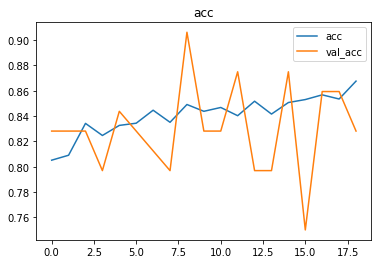

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.title('acc')

# Plot loss 

Text(0.5, 1.0, 'loss')

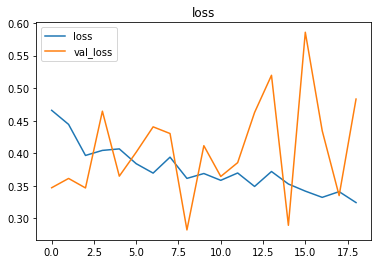

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

# 評估模型

In [ ]:
eva_x, eva_y = eva_gen.next()[0], eva_gen.next()[1]

In [ ]:
loss, acc = model.evaluate(eva_gen, steps=STEPS)
print('評估的準確率: ', acc)

  3/128 [..............................] - 2s 823ms/step - loss: 0.4297 - categorical_accuracy: 0.8220
評估的準確率:  0.8220338821411133


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

train, label = eva_gen.next()

pre = model.predict(train, steps= 1)
pre = pre.argmax(axis= -1)
label = label.argmax(axis= -1)

df = pd.DataFrame(confusion_matrix(label, pre))
df

,0,1,2
0,11,0,0
1,3,9,0
2,1,4,16
